# Train Food Recognition Model

This notebook trains a food recognition model using EfficientNetV2B3 on the Food-101 dataset, with enhanced data augmentation, mixed precision training, and progressive fine-tuning, for the AI-Powered Meal Image Analysis project.

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
import os
import time
import json
from typing import List
from datetime import datetime

# Enable mixed precision for faster training on compatible GPUs
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## Configure Parameters

Set up model configuration parameters.

In [101]:
# Configuration
IMG_SIZE = 300  # Optimal for EfficientNetV2B3
BATCH_SIZE = 32  # Better for most GPUs
NUM_CLASSES = 101  # Food-101 dataset
AUTOTUNE = tf.data.AUTOTUNE  # Automatic tuning of pipeline parallelism
EPOCHS = 30  # Maximum number of epochs
FINE_TUNE_EPOCHS = 10 # Maximum number of epochs for the fine tuning the model
BASE_LR = 0.001  # Initial learning rate
FINE_TUNE_LR = 0.0001  # Fine-tuning learning rate

# Directories
TRAIN_DIR = '../data/food101/train'
VALID_DIR = '../data/food101/validation'
TEST_DIR = '../data/food101/test'
MODEL_DIR = '../models'
IMAGE_DIR = '../images'
os.makedirs(MODEL_DIR, exist_ok=True)

## Create Data Pipelines

Using tf.data API for efficient data loading and augmentation.

In [3]:
def create_data_augmentation():
    """Create a sequential model with data augmentation layers."""
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.GaussianNoise(0.1),
    ])
    return data_augmentation

In [4]:
def preprocess_image(image, label):
    """Preprocess images using EfficientNetV2 preprocessing."""
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image)
    return image, label

In [5]:
def create_dataset(directory, is_training=False):
    """Create an optimized tf.data.Dataset from directory and return class names."""
    # Load dataset from directory
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=is_training
    )
    
    # Capture class names before transformations
    class_names = dataset.class_names
    
    # Apply preprocessing
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    # Apply augmentation if training
    if is_training:
        data_augmentation = create_data_augmentation()
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )
    
    # Optimize performance
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset, class_names

In [6]:
# Create datasets
print("Creating datasets...")
train_dataset, class_names = create_dataset(TRAIN_DIR, is_training=True)
validation_dataset, _ = create_dataset(VALID_DIR)
test_dataset, _ = create_dataset(TEST_DIR)

Creating datasets...
Found 70700 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.


In [7]:
print(f"Class names: {class_names}")
print(f"Number of classes: {len(class_names)}")
images, labels = next(iter(train_dataset))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Class names: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macaron

## Visualize Data

Display a batch of training images with augmentation.

In [8]:
def show_batch(dataset, class_names):
    """Visualize a batch of images from a dataset."""
    plt.figure(figsize=(12, 12))
    images, labels = next(iter(dataset))
    # Convert images to float32 and normalize to [0, 1] for visualization
    images = tf.cast(images, tf.float32)
    images = (images - tf.reduce_min(images)) / (tf.reduce_max(images) - tf.reduce_min(images))
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show();

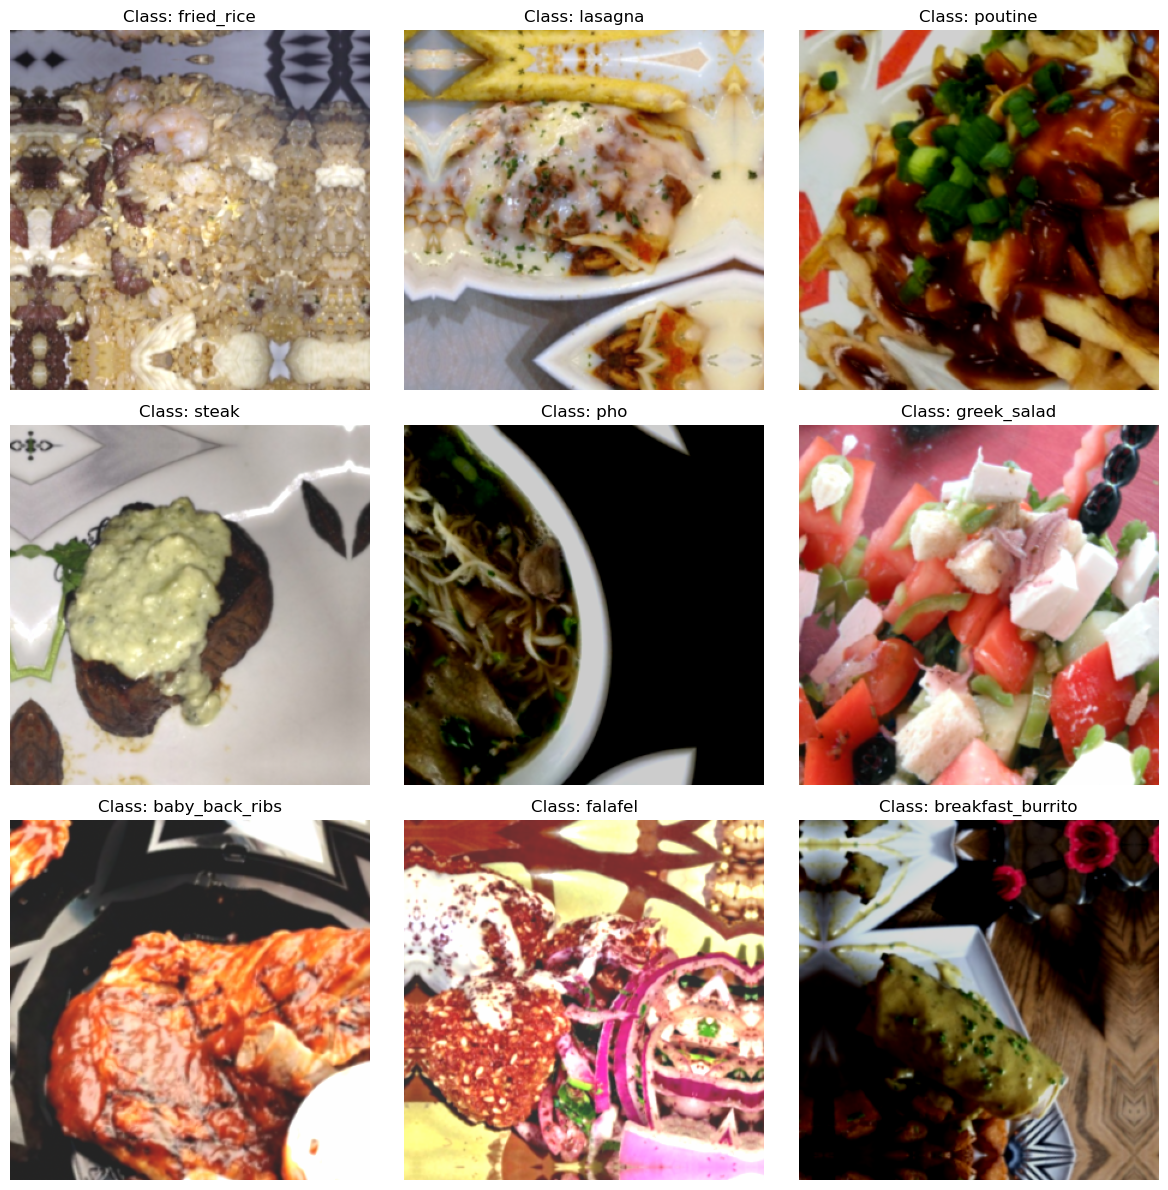

In [22]:
# Visualize a batch of training data
show_batch(train_dataset, class_names)

## Build Model

Create a transfer learning model based on EfficientNetV2B3 with custom classification layers.

In [9]:
def build_food_recognition_model():
    """Build a transfer learning model for food recognition."""
    # Load pre-trained EfficientNetV2B3
    base_model = EfficientNetV2B3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Define input shape
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Apply base model
    x = base_model(inputs, training=False)
    
    # Add global pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # Add batch normalization for better training stability
    x = layers.BatchNormalization()(x)
    
    # Add dense layers with dropout and batch normalization
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=BASE_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5_accuracy")]
    )
    
    return model

In [10]:
# Build model
model = build_food_recognition_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,884,067 (52.96 MB)

 Trainable params: 948,837 (3.62 MB)

 Non-trainable params: 12,935,230 (49.34 MB)

## Train Model

Train the model with callbacks for early stopping, checkpoint saving, and learning rate reduction.

In [14]:
def create_callbacks():
    """Create training callbacks."""
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
        filepath=os.path.join(MODEL_DIR, 'food_recognition_checkpoint.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join(MODEL_DIR, 'logs', time.strftime("%Y%m%d-%H%M%S")),
        histogram_freq=1
    )
    
    return [early_stopping, checkpoint, reduce_lr, tensorboard]

In [16]:
# Initial training
print("Starting initial training...")
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Starting initial training...
Epoch 1/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.2298 - loss: 3.3312 - top5_accuracy: 0.4698
Epoch 1: val_accuracy improved from -inf to 0.54647, saving model to ../models/food_recognition_checkpoint.keras
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2625s 1s/step - accuracy: 0.2298 - loss: 3.3310 - top5_accuracy: 0.4699 - val_accuracy: 0.5465 - val_loss: 1.6768 - val_top5_accuracy: 0.8270 - learning_rate: 0.0010
Epoch 2/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.3896 - loss: 2.4430 - top5_accuracy: 0.6788
Epoch 2: val_accuracy improved from 0.54647 to 0.58376, saving model to ../models/food_recognition_checkpoint.keras
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 2598s 1s/step - accuracy: 0.3896 - loss: 2.4430 - top5_accuracy: 0.6788 - val_accuracy: 0.5838 - val_loss: 1.5380 - val_top5_accuracy: 0.8500 - learning_rate: 0.0010
Epoch 3/30
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.4205 - loss: 2.3023 - top5_accuracy: 0.7090
Epoch 

## Fine-tune Model

Unfreeze and fine-tune the base model with a lower learning rate.

In [63]:
def fine_tune_model(model, fine_tune_lr=FINE_TUNE_LR, unfreeze_percentage=0.3):
    """
    Fine-tune the model by unfreezing part of the base model.
    
    Args:
        model: The model to fine-tune
        fine_tune_lr: Learning rate for fine-tuning (default: value from config)
        unfreeze_percentage: Percentage of layers to unfreeze from the end (default: 0.3 or 30%)
        
    Returns:
        Compiled model ready for fine-tuning
    """
    
    base_model = model.layers[1]  # Get the base model
    
    # Calculate unfreezing points based on percentage
    total_layers = len(base_model.layers)
    fine_tune_at = int(total_layers * (1 - unfreeze_percentage))
    print(f"Total layers in base model: {total_layers}")
    print(f"Unfreezing from layer {fine_tune_at} to {total_layers}")
    
    # Unfreeze layers for fine-tuning
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    # Define additional metrics - with proper configuration for multi-class
    # Use CategoricalAccuracy instead of Accuracy for one-hot encoded targets
    cat_accuracy = tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
    precision = tf.keras.metrics.Precision(name='precision')
    recall = tf.keras.metrics.Recall(name='recall')
    auc = tf.keras.metrics.AUC(name='auc')
    
    # Fix for F1Score - set average='macro' to get a scalar output
    f1_score = tf.keras.metrics.F1Score(
        name='f1_score',
        average='macro',  # Use macro averaging to get a scalar
        threshold=None  # Needed for multi-class problems
    )
    
    # Recompile with lower learning rate from configuration
    model.compile(
        optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',  # Use string version which is appropriate for categorical data
            cat_accuracy,  # Explicit CategoricalAccuracy
            precision,
            recall,
            auc,
            f1_score,
            tf.keras.metrics.TopKCategoricalAccuracy(k=5, name="top5_accuracy"),
            tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3_accuracy")
        ]
    )
    
    # Show which layers are trainable
    print("\nTrainable layers:")
    trainable_count = 0
    total_count = 0
    trainable_params = 0
    non_trainable_params = 0
    
    for layer in model.layers:
        if hasattr(layer, 'layers'):  # For nested models like base_model
            for inner_layer in layer.layers:
                total_count += 1
                layer_params = sum([tf.keras.backend.count_params(w) for w in inner_layer.weights])
                
                if inner_layer.trainable:
                    trainable_count += 1
                    trainable_params += layer_params
                else:
                    non_trainable_params += layer_params
        else:
            total_count += 1
            layer_params = sum([tf.keras.backend.count_params(w) for w in layer.weights])
            
            if layer.trainable:
                trainable_count += 1
                trainable_params += layer_params
            else:
                non_trainable_params += layer_params
    
    print(f"Total of {trainable_count} trainable layers out of {total_count}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    print(f"Total parameters: {trainable_params + non_trainable_params:,}")
    
    # Create and display model learning rate schedule
    print("\nLearning rate schedule:")
    print(f"Fine-tuning learning rate: {fine_tune_lr}")
    
    # Display dataset information
    print(f"\nTraining on Food-101 dataset with {NUM_CLASSES} classes")
    print(f"Image size: {IMG_SIZE}x{IMG_SIZE}, Batch size: {BATCH_SIZE}")
    
    return model

In [64]:
# Fine-tune model
model_fine_tune = fine_tune_model(model)

Total layers in base model: 409
Unfreezing from layer 286 to 409

Trainable layers:
Total of 135 trainable layers out of 421
Trainable parameters: 7,983,157
Non-trainable parameters: 5,900,910
Total parameters: 13,884,067

Learning rate schedule:
Fine-tuning learning rate: 0.0001

Training on Food-101 dataset with 101 classes
Image size: 300x300, Batch size: 32


In [65]:
# Fine-tune training
print("\nStarting fine-tuning...")


Starting fine-tuning...


In [66]:
# Create early stopping callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [67]:
# Create learning rate reducer to adjust learning rate during training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [68]:
# Combine with existing callbacks
fine_tune_callbacks = callbacks + [early_stopping, reduce_lr]

In [69]:
# Ensure model is properly prepared for fine-tuning
print("Verifying model is ready for fine-tuning...")

Verifying model is ready for fine-tuning...


In [70]:
# Check if any layers are trainable
trainable_params = sum(K.count_params(w) for w in model_fine_tune.trainable_weights)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 7,927,221


In [71]:
if trainable_params == 0:
    print("WARNING: No trainable parameters! Running fine_tune_model function...")
    model_fine_tune = fine_tune_model(model_fine_tune, fine_tune_lr=FINE_TUNE_LR)

In [72]:
# Reset initial epoch to make sure training happens
initial_epoch = 0

In [73]:
total_epochs = FINE_TUNE_EPOCHS

In [74]:
# Save checkpoint of the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(MODEL_DIR, 'food101_fine_tuned_best.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [75]:
fine_tune_callbacks.append(checkpoint)

In [76]:
print("\nStarting fine-tuning...")
fine_tune_history = model_fine_tune.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    initial_epoch=initial_epoch, 
    callbacks=fine_tune_callbacks,
    verbose=1 
)


Starting fine-tuning...
Epoch 1/10
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5677 - auc: 0.9628 - categorical_accuracy: 0.5677 - f1_score: 0.5607 - loss: 1.6616 - precision: 0.8185 - recall: 0.4089 - top3_accuracy: 0.7515 - top5_accuracy: 0.8226
Epoch 1: val_accuracy improved from 0.68330 to 0.73729, saving model to ../models/food_recognition_checkpoint.keras

Epoch 1: val_accuracy improved from -inf to 0.73729, saving model to ../models/food101_fine_tuned_best.keras
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 3645s 2s/step - accuracy: 0.5677 - auc: 0.9628 - categorical_accuracy: 0.5677 - f1_score: 0.5607 - loss: 1.6616 - precision: 0.8185 - recall: 0.4089 - top3_accuracy: 0.7515 - top5_accuracy: 0.8226 - val_accuracy: 0.7373 - val_auc: 0.9827 - val_categorical_accuracy: 0.7373 - val_f1_score: 0.7344 - val_loss: 0.9611 - val_precision: 0.8721 - val_recall: 0.6465 - val_top3_accuracy: 0.8810 - val_top5_accuracy: 0.9220 - learning_rate: 1.0000e-04
Epoch 2/10
2210/2210 ━━━━━━━━━━━━━━━━━

## Visualize Results

Plot training and validation metrics.

In [106]:
def plot_training_history(
    history: tf.keras.callbacks.History,
    fine_tune_history: tf.keras.callbacks.History | None = None
) -> None:
    """Plot training and validation metrics, including fine-tuning.

    Args:
        history: Training history from initial training.
        fine_tune_history: Optional history from fine-tuning.
    """
    # Extract metrics
    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'top5_accuracy', 'val_top5_accuracy']
    data = {key: history.history.get(key, []) for key in metrics}
    
    # Validate history
    if not data['accuracy']:
        raise ValueError("History missing 'accuracy'. Check training output.")
    
    # Append fine-tuning data
    if fine_tune_history is not None:
        if not fine_tune_history.history.get('accuracy'):
            raise ValueError("Fine-tune history missing 'accuracy'.")
        for key in metrics:
            data[key] += fine_tune_history.history.get(key, [])
    
    epochs_range = range(len(data['accuracy']))
    
    # Create plots
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, data['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, data['val_accuracy'], label='Validation Accuracy')
    if fine_tune_history:
        fine_tune_start = len(history.history['accuracy']) - 0.5
        plt.axvline(x=fine_tune_start, color='r', linestyle='--')
        plt.text(fine_tune_start + 0.5, min(data['val_accuracy']) + 0.1, 
                 'Fine-tuning', color='r', rotation=90)
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    
    # Top-5 Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, data['top5_accuracy'], label='Training Top-5 Accuracy')
    plt.plot(epochs_range, data['val_top5_accuracy'], label='Validation Top-5 Accuracy')
    if fine_tune_history:
        plt.axvline(x=fine_tune_start, color='r', linestyle='--')
        plt.text(fine_tune_start + 0.5, min(data['val_top5_accuracy']) + 0.1, 
                 'Fine-tuning', color='r', rotation=90)
    plt.legend(loc='lower right')
    plt.title('Top-5 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Top-5 Accuracy')
    
    # Loss plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, data['loss'], label='Training Loss')
    plt.plot(epochs_range, data['val_loss'], label='Validation Loss')
    if fine_tune_history:
        plt.axvline(x=fine_tune_start, color='r', linestyle='--')
        plt.text(fine_tune_start + 0.5, max(data['val_loss']) - 0.5, 
                 'Fine-tuning', color='r', rotation=90)
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.tight_layout()
    
    # Save plot
    try:
        os.makedirs(IMAGE_DIR, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plot_path = os.path.join(IMAGE_DIR, f'training_history_{timestamp}.png')
        plt.savefig(plot_path, dpi=300)
        print(f"Plot saved to {plot_path}")
    except Exception as e:
        print(f"Failed to save plot: {e}")
        plot_path = os.path.join(MODEL_DIR, 'training_history_fallback.png')
        plt.savefig(plot_path, dpi=300)
        print(f"Saved to fallback: {plot_path}")
    
    plt.show()
    plt.close();

Plot saved to ../images/training_history_20250414_033626.png


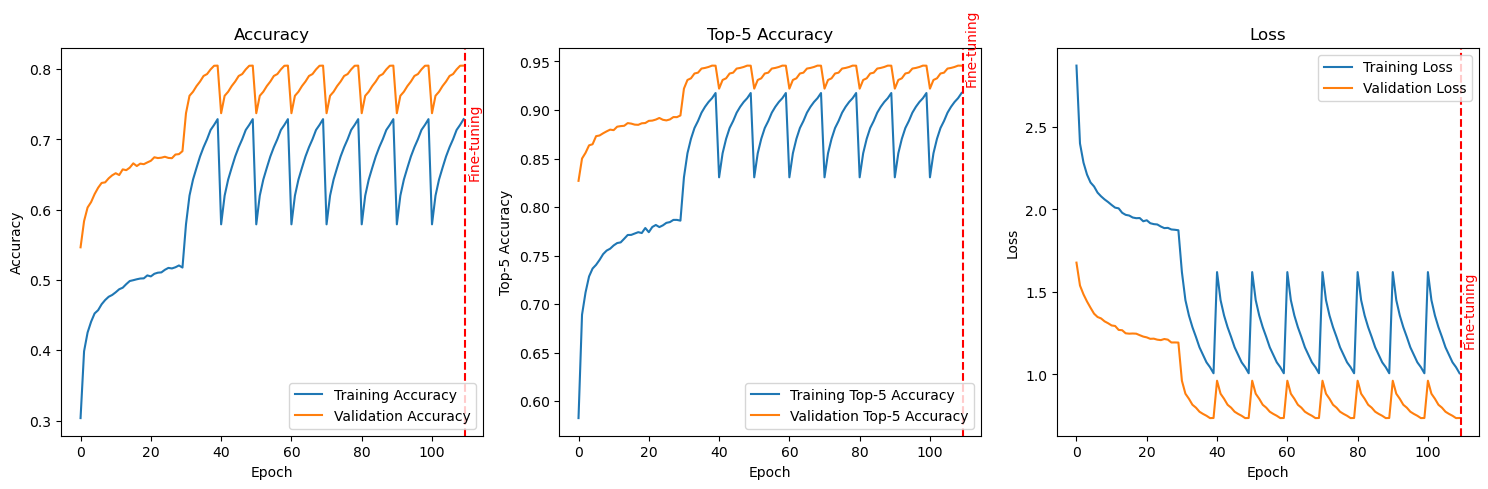

In [107]:
# Plot the combined training history
plot_training_history(history, fine_tune_history)

## Save Model

Save the final model in SavedModel format for better compatibility.

In [117]:
def save_model_and_classes(model: tf.keras.Model, class_names: List[str]) -> None:
    """Save the model in SavedModel and Keras formats, and class names as JSON.

    Args:
        model: Trained Keras model to save.
        class_names: List of class names for inference.
    """
    # Validate inputs
    if not isinstance(model, tf.keras.Model):
        raise ValueError("Model must be a tf.keras.Model instance.")
    if not class_names or not isinstance(class_names, list):
        raise ValueError("class_names must be a non-empty list of strings.")
    
    # Ensure MODEL_DIR exists
    os.makedirs(MODEL_DIR, exist_ok=True)
    
    # Save in SavedModel format (for inference)
    saved_model_path = os.path.join(MODEL_DIR, 'food_recognition_model')
    try:
        model.export(saved_model_path)
        print(f"SavedModel saved to {saved_model_path}")
    except Exception as e:
        print(f"Failed to save SavedModel: {e}")
        raise
    
    # Save in Keras format (for reloading)
    keras_path = os.path.join(MODEL_DIR, 'food_recognition_model.keras')
    try:
        model.save(keras_path)
        print(f"Keras model saved to {keras_path}")
    except Exception as e:
        print(f"Failed to save Keras model: {e}")
        raise
    
    # Save class names
    class_names_path = os.path.join(MODEL_DIR, 'class_names.json')
    try:
        with open(class_names_path, 'w') as f:
            json.dump(class_names, f, indent=2)
        print(f"Class names saved to {class_names_path}")
    except Exception as e:
        print(f"Failed to save class names: {e}")
        raise

In [118]:
# Save model and class names
save_model_and_classes(model, class_names)

INFO:tensorflow:Assets written to: ../models/food_recognition_model/assets


INFO:tensorflow:Assets written to: ../models/food_recognition_model/assets


Saved artifact at '../models/food_recognition_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='keras_tensor_418')
Output Type:
  TensorSpec(shape=(None, 101), dtype=tf.float32, name=None)
Captures:
  12958012288: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  12958012112: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  12958013344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958013696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958013520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958014224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958013872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958013168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958014576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958014048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12958015280: T

## Evaluate Model

Evaluate the model on the test dataset.

In [78]:
def evaluate_model(model, test_dataset):
    """Evaluate the model on the test dataset."""
    print("Evaluating model on test dataset...")
    results = model.evaluate(test_dataset)
    print(f"Test loss: {results[0]:.4f}")
    print(f"Test accuracy: {results[1]:.4f}")
    print(f"Test top-5 accuracy: {results[2]:.4f}")

In [79]:
# Evaluate on test dataset
evaluate_model(model, test_dataset)

Evaluating model on test dataset...
474/474 ━━━━━━━━━━━━━━━━━━━━ 451s 950ms/step - accuracy: 0.7904 - auc: 0.9823 - categorical_accuracy: 0.7904 - f1_score: 0.4172 - loss: 0.7922 - precision: 0.8712 - recall: 0.7428 - top3_accuracy: 0.9124 - top5_accuracy: 0.9421
Test loss: 0.7584
Test accuracy: 0.7989
Test top-5 accuracy: 0.7989


## Inference Example

Demonstrate how to use the model for inference.

In [102]:
def predict_food_class(image_path, model, class_names):
    """Predict food class for a given image."""
    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32)
    img_array = tf.keras.applications.efficientnet_v2.preprocess_input(img_array)
    img_batch = tf.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_batch)
    
    # Get top 5 predictions
    top_indices = np.argsort(predictions[0])[::-1][:5]
    top_probabilities = predictions[0][top_indices]
    top_classes = [class_names[idx] for idx in top_indices]
    
    # Display results
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array / 255.0)  # Display original image
    plt.title("Input Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    bars = plt.barh(range(5), top_probabilities * 100)
    plt.yticks(range(5), top_classes)
    plt.xlabel("Probability (%)")
    plt.title("Top 5 Predictions")
    plt.tight_layout()
    plt.show()
    
    return {class_name: float(prob) for class_name, prob in zip(top_classes, top_probabilities)}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


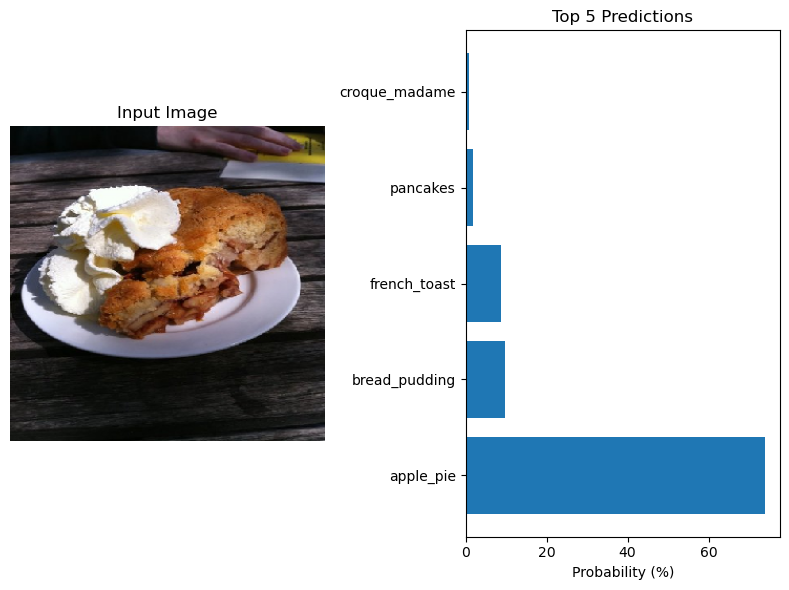

{'apple_pie': 0.7388883233070374,
 'bread_pudding': 0.09688755869865417,
 'french_toast': 0.08829565346240997,
 'pancakes': 0.01831856556236744,
 'croque_madame': 0.00834192056208849}

In [111]:
# Example usage (uncomment and provide a path):
predict_food_class(os.path.join(TEST_DIR, 'apple_pie', '103801.jpg'), model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


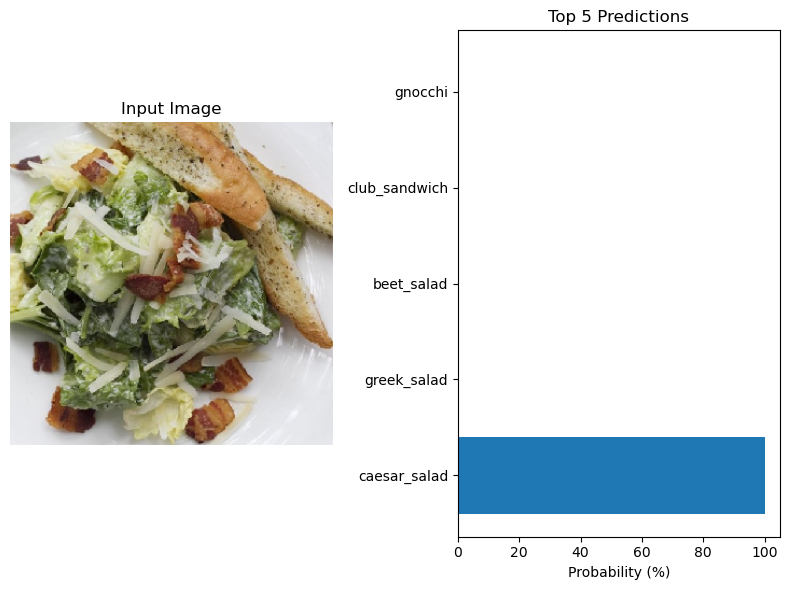

{'caesar_salad': 0.9999758005142212,
 'greek_salad': 1.9156148482579738e-05,
 'beet_salad': 3.1610286441718927e-06,
 'club_sandwich': 5.713812356589187e-07,
 'gnocchi': 1.935987796741756e-07}

In [113]:
# Example usage (uncomment and provide a path):
predict_food_class(os.path.join(TEST_DIR, 'caesar_salad', '283679.jpg'), model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


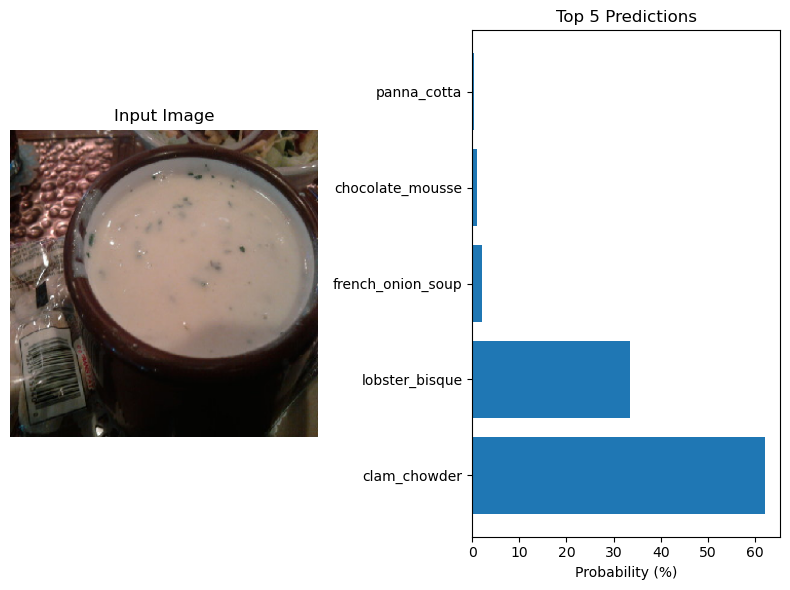

{'clam_chowder': 0.6220069527626038,
 'lobster_bisque': 0.3342590928077698,
 'french_onion_soup': 0.02168598398566246,
 'chocolate_mousse': 0.009356429800391197,
 'panna_cotta': 0.004510207567363977}

In [114]:
predict_food_class(os.path.join(TEST_DIR, 'clam_chowder', '230755.jpg'), model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


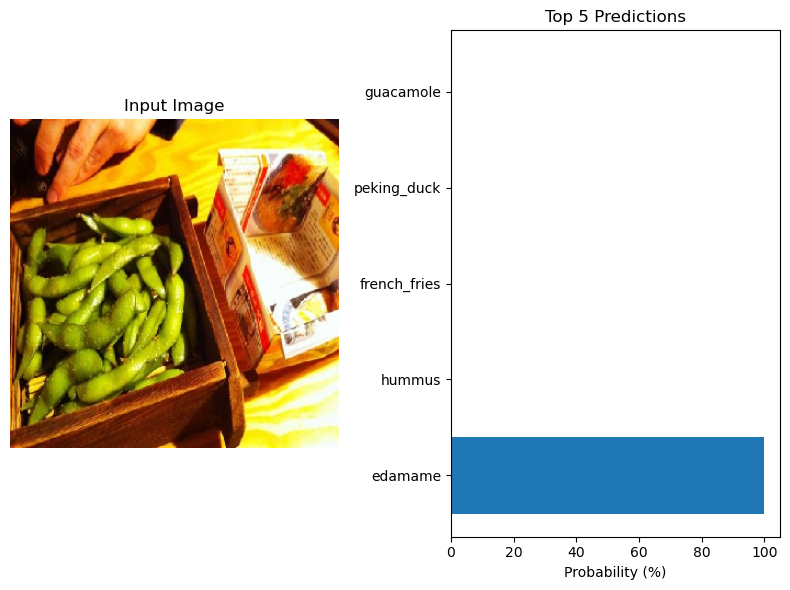

{'edamame': 0.9999955892562866,
 'hummus': 7.411227898046491e-07,
 'french_fries': 4.7278035708586685e-07,
 'peking_duck': 4.0632178865962487e-07,
 'guacamole': 3.691257006721571e-07}

In [120]:
predict_food_class(os.path.join(TEST_DIR, 'edamame', '280078.jpg'), model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


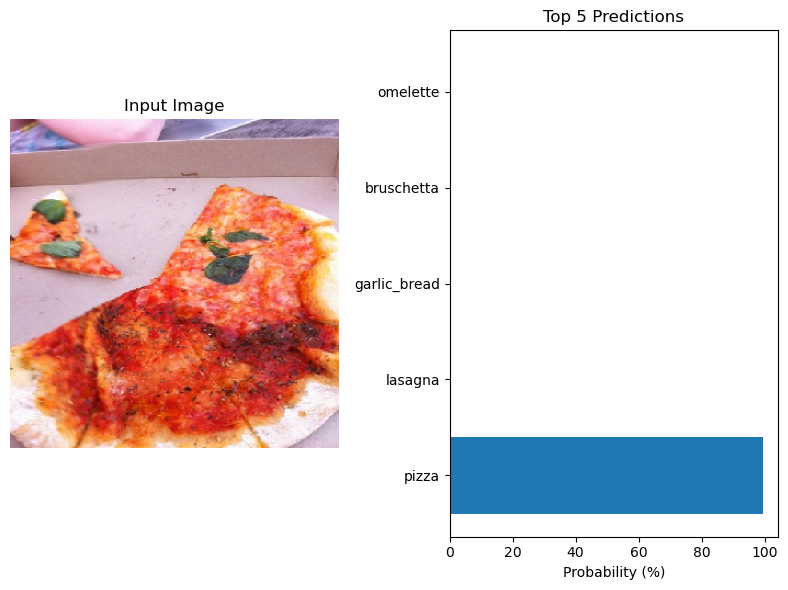

{'pizza': 0.9933251738548279,
 'lasagna': 0.0027817978989332914,
 'garlic_bread': 0.0017539669061079621,
 'bruschetta': 0.0016421711770817637,
 'omelette': 0.00013643053534906358}

In [124]:
# food-101/images/pizza/102037.jpg
predict_food_class(os.path.join(TEST_DIR, 'pizza', '218711.jpg'), model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


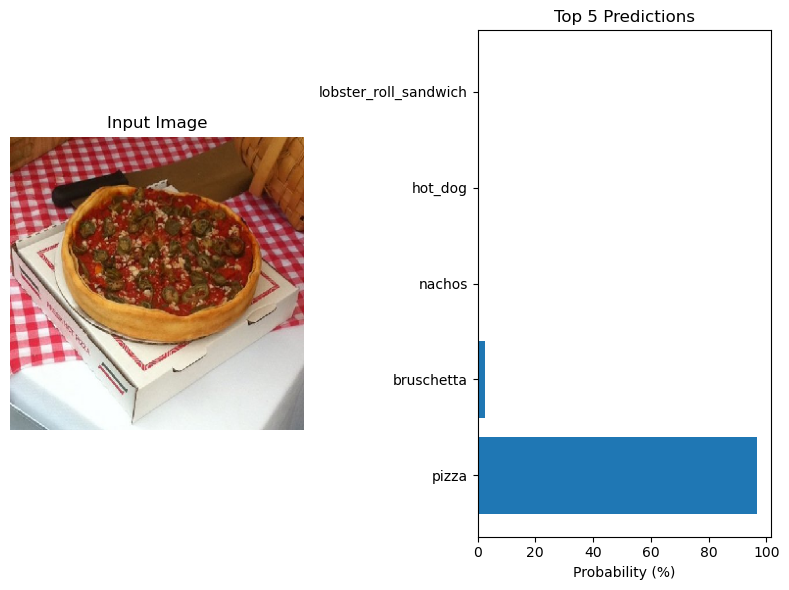

{'pizza': 0.9688436985015869,
 'bruschetta': 0.026137825101614,
 'nachos': 0.0009648469858802855,
 'hot_dog': 0.0006443997262977064,
 'lobster_roll_sandwich': 0.0006351725896820426}

In [127]:
# data/food101/food-101/images/pizza/102037.jpg
predict_food_class('../data/food101/food-101/images/pizza/102037.jpg', model, class_names)